In [6]:
from utils import *

In [25]:
df, train, test, val = get_data(normalize=False, binary_label=True)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

regressor = KNeighborsClassifier(n_neighbors=5)

test_model(regressor, train, test, classification=True)

Time taken to train the model:  0.0071773529052734375
Binary cross entropy: 14.155623237950662
Predicted mean: 0.5101526043637281 Actual mean: 0.5353764661369655
Accuracy: 0.6072644721906924


0.6072644721906924

Trying hyperparameters: 1
Time taken to train the model:  0.003627777099609375
Binary cross entropy: 16.22333760459238
Predicted mean: 0.5251458300488727 Actual mean: 0.527825949865994
Accuracy: 0.5498975248305218
Value: 0.5498975248305218
Trying hyperparameters: 6
Time taken to train the model:  0.006171703338623047
Binary cross entropy: 15.75169591591246
Predicted mean: 0.41431499290556517 Actual mean: 0.527825949865994
Accuracy: 0.5629828157023491
Value: 0.5629828157023491
Trying hyperparameters: 11
Time taken to train the model:  0.001811981201171875
Binary cross entropy: 15.353925817025784
Predicted mean: 0.5489516001891849 Actual mean: 0.527825949865994
Accuracy: 0.574018603184613
Value: 0.574018603184613
Trying hyperparameters: 16
Time taken to train the model:  0.0018622875213623047
Binary cross entropy: 15.348243387041688
Predicted mean: 0.48289452940249095 Actual mean: 0.527825949865994
Accuracy: 0.5741762572915025
Value: 0.5741762572915025
Trying hyperparameters: 21
Time tak

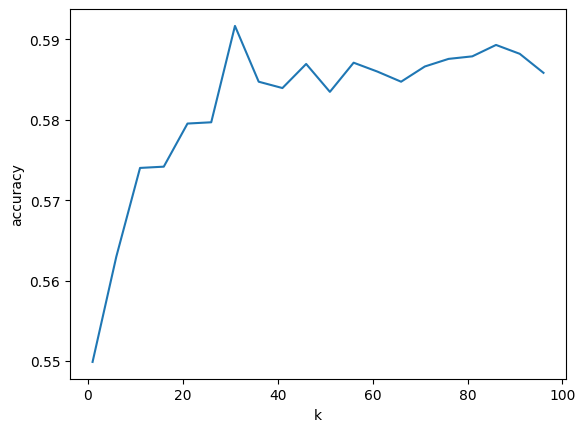

Time taken to train the model:  0.002452373504638672
Binary cross entropy: 14.751123123683334
Predicted mean: 0.5718249463992937 Actual mean: 0.5353764661369655
Accuracy: 0.5907428427292218


0.5907428427292218

In [26]:
def get_model(param):
    return KNeighborsClassifier(n_neighbors=param)

best_param, params, accuracies = optimize_hyperparameters(get_model, range(1,100,5), train, test, val,
                                                          classification=True)
plot_2d(params, accuracies, 'k', 'accuracy')
regressor = KNeighborsClassifier(n_neighbors=best_param)

test_model(regressor, train, test, classification=True)

In [27]:

from scipy.spatial.distance import cdist


class ScratchKNeighbors:
    def __init__(self, classification, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
        self.classification = classification

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        distances = cdist(X_test, self.X_train)
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        nearest_targets = self.y_train[nearest_indices]
        predictions = np.mean(nearest_targets, axis=1)
        if self.classification:  #Majority vote is useless
            return predictions >= 0.5
        return predictions


In [29]:
regressor = ScratchKNeighbors(classification=True, n_neighbors=5)
test_model(regressor, train, test, classification=True)

Time taken to train the model:  5.0067901611328125e-06
Binary cross entropy: 15.382989414651588
Predicted mean: 0.5419346701980073 Actual mean: 0.5353764661369655
Accuracy: 0.5732122587968218


0.5732122587968218

In [30]:
df, train, test, val = get_data(normalize=False, binary_label=False)


In [31]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=5)

test_model(regressor, train, test, classification=False)

Time taken to train the model:  0.0025200843811035156
Mean Squared Error: 86762363.17817126
Root Mean Squared Error: 9314.63167163207
R-squared Score: -0.22892257989135567


86762363.17817126

Trying hyperparameters: 1
Time taken to train the model:  0.0027136802673339844
Mean Squared Error: 231828766.61942297
Root Mean Squared Error: 15225.924163065538
R-squared Score: -3.053803389720369
Value: 231828766.61942297
Trying hyperparameters: 6
Time taken to train the model:  0.0010716915130615234
Mean Squared Error: 72094168.36697935
Root Mean Squared Error: 8490.828485311627
R-squared Score: -0.26065280149166026
Value: 72094168.36697935
Trying hyperparameters: 11
Time taken to train the model:  0.0011839866638183594
Mean Squared Error: 64894120.043930784
Root Mean Squared Error: 8055.688675956313
R-squared Score: -0.13475134101397956
Value: 64894120.043930784
Trying hyperparameters: 16
Time taken to train the model:  0.0012631416320800781
Mean Squared Error: 61561673.173883244
Root Mean Squared Error: 7846.124723319356
R-squared Score: -0.07647951989853241
Value: 61561673.173883244
Trying hyperparameters: 21
Time taken to train the model:  0.0014309883117675781
Mean Squared Err

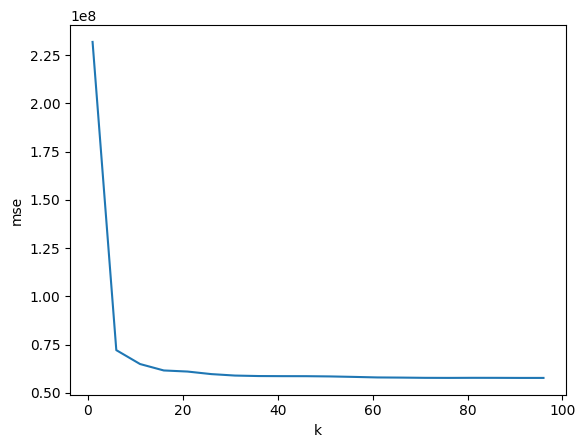

Time taken to train the model:  0.001337289810180664
Mean Squared Error: 70729278.91917223
Root Mean Squared Error: 8410.070090027326
R-squared Score: -0.0018261921325006814


70729278.91917223

In [32]:
def get_model(param):
    return KNeighborsRegressor(n_neighbors=param)

best_param, params, accuracies = optimize_hyperparameters(get_model, range(1,100,5), train, test, val,
                                                          classification=False)
plot_2d(params, accuracies, 'k', 'mse')
regressor = KNeighborsRegressor(n_neighbors=best_param)

test_model(regressor, train, test, classification=False)

In [22]:
regressor = ScratchKNeighbors(classification=False)
test_model(regressor, train, test, classification=False)


Time taken to train the model:  5.0067901611328125e-06
Mean Squared Error: 86762363.17817126
Root Mean Squared Error: 9314.63167163207
R-squared Score: -0.22892257989135567


86762363.17817126

In [30]:
class ScratchLocallyWeightedLinearRegression:
    def __init__(self, num_iter, lr, kernel_func, kernel_func_params):
        self.num_iter = num_iter
        self.lr = lr
        self.kernel_func = kernel_func
        self.kernel_func_params = kernel_func_params
        self.w = None

    def fit(self, X, y):
        self.w = np.random.rand(X.shape[1])
        for i in range(self.num_iter):
            for j in range(X.shape[0]):
                x = X[j]
                y_pred = self.predict(x)
                error = y[j] - y_pred
                k = self.kernel_func(x, X, self.kernel_func_params)

                # self.w += self.lr * error * k
                # self.w+=self.lr *error * np.dot(k,x)

                self.w += self.lr * np.dot(error, k)

    def predict(self, X):
        return np.dot(X, self.w)


def gaussian_kernel(x, X, params):
    sigma = params['sigma']
    distances = np.linalg.norm(x - X, axis=1)
    return np.exp(-distances ** 2 / (2 * sigma ** 2))


regressor = ScratchLocallyWeightedLinearRegression(num_iter=100, lr=0.01, kernel_func=gaussian_kernel,
                                                   kernel_func_params={'sigma': 1})

test_model(regressor, train_x, train_y, test_x, test_y)

ValueError: operands could not be broadcast together with shapes (58,) (31715,) (58,) 